### Описание датасета:



Визит клиента:
- ID визита: session_id
- ID посетителя: client_id
- Дата визита: visit_date
- Время визита: visit_time
- Порядковый номер визита клиента: visit_number
- Канал привлечения: utm_source
- Тип привлечения: utm_medium
- Рекламная кампания: utm_campaign
- Ключевое слово: utm_keyword
- Тип устройства: device_category
- ОС устройства: device_os
- Марка устройства: device_brand
- Модель устройства: device_model
- Разрешение экрана: device_screen_resolution
- Браузер: device_browser
- Страна: geo_country
- Город: geo_city
- Действие: event_action

# imports

In [ ]:
!pip install -q catboost

from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

# Аутентификация и подключение Google Диска
drive.mount('/content/drive')
gauth = GoogleAuth()
drive = GoogleDrive(gauth)

import sys
sys.path.append('/content/drive/MyDrive/AI')

# Импорт необходимых библиотек и скрипта data_processing
from data_processing import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.2 MB/s eta 0:00:00
Mounted at /content/drive


# load data

In [ ]:
# Объединение ga_hits и ga_session, сохраняя все строки из ga_hits и 'event_action' из ga_session

# df1 = pd.DF(ga_hits)
# df2 = pd.DF(ga_session)

# df2_dedup = df2[['session_id', 'event_action']].drop_duplicates()
# df = pd.merge(df1, df2_dedup, how='left', on='session_id')

# df.to_csv('/content/drive/MyDrive/AI/df.csv', index=False)
df = pd.read_csv('/content/drive/MyDrive/AI/data/df.csv')

# Data Preparation

## Data cleaning

In [ ]:
def binarize_event_action(data, col):
    # Create a new column called event_action_target
    modified_col = data[col].apply(
        lambda x: 1 if x in ['sub_car_claim_click', 'sub_car_claim_submit_click',
                             'sub_open_dialog_click', 'sub_custom_question_submit_click',
                             'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
                             'sub_car_request_submit_click'] else 0)

    return modified_col

In [ ]:
# Преобразование таргета
df['event_action'] = binarize_event_action(df, 'event_action')

In [ ]:
# Проверка пропущенных значений
process_data(df);

In [ ]:
# Удаление не информативных признаков
df = df.drop(['utm_keyword','device_os', 'device_model', 'geo_country'], axis=1)

In [ ]:
# Замена пропущенных значений и удаление дупликатов
df = process_data(df, method='mode', remove_duplicates=True, visualize=False)

## Researching Anomalies

In [ ]:
plot_outliers(df);

#Feature engineering

In [ ]:
df2 = df.copy()

In [ ]:
def categorize_feature(feature):
    # Вычисляем границы разбиения на 4 категории
    bins = np.linspace(feature.min(), feature.max(), 5)

    # Определяем метки категорий
    labels = ['Very Low', 'Low', 'Medium', 'High']

    # Используем метод cut для разбиения и категоризации признака
    return pd.cut(feature, bins=bins, labels=labels, right=False)

In [ ]:
df2['visit_number'] = categorize_feature(df2['visit_number'])

In [ ]:
df2['visit_date'] = pd.to_datetime(df2['visit_date'])
df2['visit_time'] = pd.to_datetime(df2['visit_time'])
df2['visit_hour'] = df2['visit_time'].dt.hour
df2['part_of_day'] = pd.cut(df2['visit_hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], include_lowest=True)
df2['day_of_week'] = df2['visit_date'].dt.dayofweek
df2['is_weekend'] = df2['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Количество визитов по источникам
df2['visit_counts_by_source'] = df2.groupby(['client_id', 'utm_source'])['visit_time'].transform('count')

# Предпочитаемый канал пользователя
df2['preferred_utm_source'] = df2.groupby('client_id')['utm_source'].transform(lambda x: x.mode()[0])

# Удаляем исходные колонки
df2 = df2.drop(['visit_date', 'visit_time'], axis=1)

#Data Standardization

In [ ]:
#df2.to_csv('/content/drive/MyDrive/new_data2.csv', index=False)

In [ ]:
df2 =  pd.read_csv('/content/drive/MyDrive/AI/data/new_data2.csv')

In [ ]:
# выбираем 1 500 000 случайных строк из 2 000 000
# это исключительный подход из-за недостатка вычислительных мощностей на пк
sample_df = df2.sample(n=1500000)

In [ ]:
X = sample_df.drop(['session_id', 'client_id', 'event_action'], axis=1)
y = sample_df[['event_action']]

In [ ]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
columns = ['utm_source',
           'utm_medium',
           'utm_campaign',
           'utm_adcontent',
           'device_category',
           'device_brand',
           'device_screen_resolution',
           'device_browser',
           'geo_city']

In [ ]:
class ProbabilityEncoder:
    def __init__(self, columns=None, id_column=None):
        self.columns = columns
        self.id_column = id_column
        self.percentage_dicts = {}

    def fit(self, X, y):
        data = pd.concat([X, y], axis=1)
        self.columns = self.columns if self.columns else data.columns.tolist()
        self.id_column = self.id_column if self.id_column else data.columns[0]
        self.target = data.columns[-1]

        for column in self.columns:
            total_counts = data.groupby(column)[self.target].count()
            positive_counts = data.groupby(column)[self.target].sum()
            percentages = (positive_counts / total_counts) * 100
            self.percentage_dicts[column] = percentages.to_dict()

        return self

    def transform(self, X):
        data = X.copy()
        for column, percentages in self.percentage_dicts.items():
            data[column] = data[column].map(percentages).fillna(0)

        return data

    def fit_transform(self, X, y):
        self.fit(X, y)
        transformed_data = self.transform(X)
        return transformed_data, self.percentage_dicts

In [ ]:
# Преобразуем значения признаков в вероятности совершения целевого действия
prob_encoder = ProbabilityEncoder(columns=columns, id_column='client_id')

In [ ]:
X_train_encoded, percentage_dicts = prob_encoder.fit_transform(X_train, y_train)

In [ ]:
X_train_encoded = prob_encoder.transform(X_train)
X_test_encoded = prob_encoder.transform(X_test)

In [ ]:
# Создание экземпляра класса
preprocessor = DataPreprocessor()

In [ ]:
# Обучение преобразований на обучающих данных
preprocessor.fit(X_train_encoded)

In [ ]:
# Применение обученных преобразований к обучающим и тестовым данным
X_train_transformed = preprocessor.transform(X_train_encoded)
X_test_transformed = preprocessor.transform(X_test_encoded)

#Modeling


In [ ]:
trainer = ModelTrainer(task_type='classification', balance=True)

In [ ]:
best_model, trained_models = trainer.train_and_evaluate(X_train_transformed, y_train, X_test_transformed, y_test)

Model: LogisticRegression, ROC_AUC: 0.6235684453111376
Model: RandomForestClassifier, ROC_AUC: 0.5148158562280276
Model: GradientBoostingClassifier, ROC_AUC: 0.7647477551628681
Model: CatBoostClassifier, ROC_AUC: 0.5182208906501711
Model: LGBMClassifier, ROC_AUC: 0.5557243150705332

Best model: GradientBoostingClassifier, with Score: 0.7647477551628681


In [ ]:
def plot_model(X_test, y_test, model=None, visualize=True):
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"\nROC AUC Score:\n{roc_auc}")
    df_classification_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

    if visualize:
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted class")
        plt.ylabel("True class")
        plt.show()

        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

    print("\nClassification Report:")
    display(df_classification_report)
    print(f"{'=='*40}\n")

    return roc_auc

Results for LogisticRegression:

ROC AUC Score:
0.6235684453111376


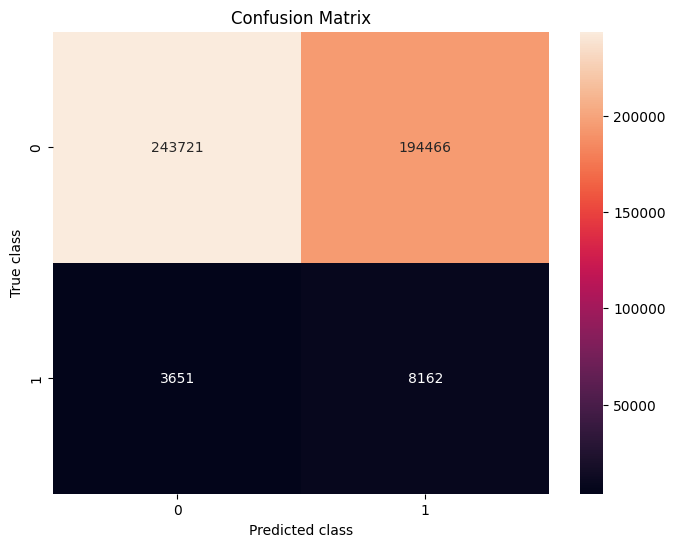

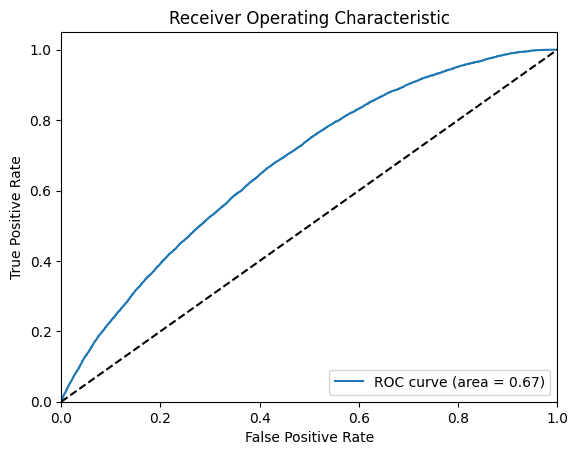


Classification Report:


,precision,recall,f1-score,support
0,0.985241,0.556203,0.711014,438187.00000
1,0.040281,0.690934,0.076124,11813.00000
accuracy,0.559740,0.559740,0.559740,0.55974
macro avg,0.512761,0.623568,0.393569,450000.00000
weighted avg,0.960435,0.559740,0.694347,450000.00000



Results for RandomForestClassifier:

ROC AUC Score:
0.5148158562280276


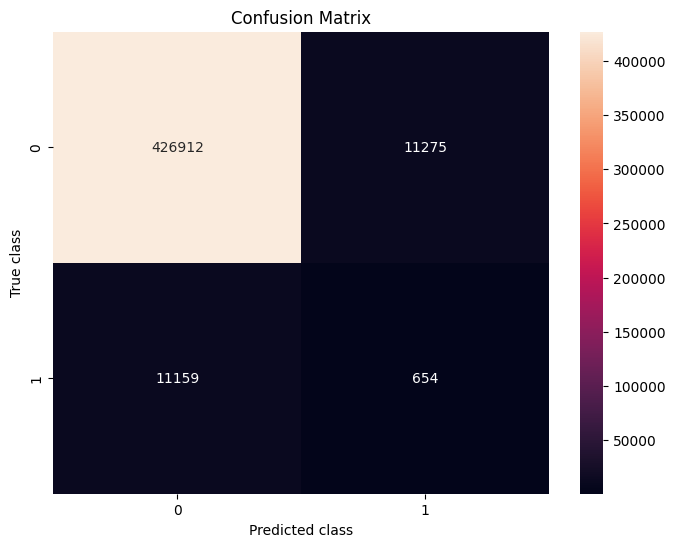

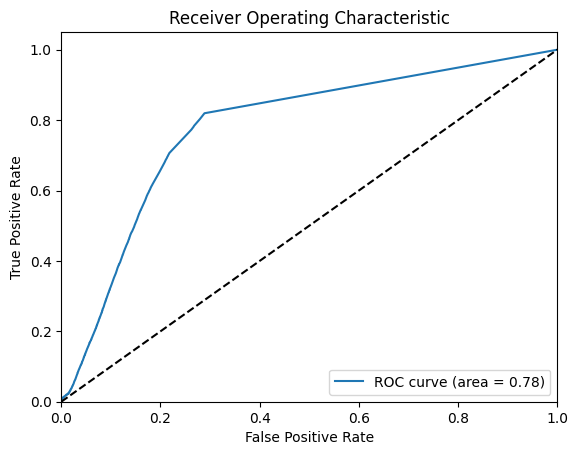


Classification Report:


,precision,recall,f1-score,support
0,0.974527,0.974269,0.974398,438187.000000
1,0.054824,0.055363,0.055092,11813.000000
accuracy,0.950147,0.950147,0.950147,0.950147
macro avg,0.514676,0.514816,0.514745,450000.000000
weighted avg,0.950384,0.950147,0.950265,450000.000000



Results for GradientBoostingClassifier:

ROC AUC Score:
0.7647477551628681


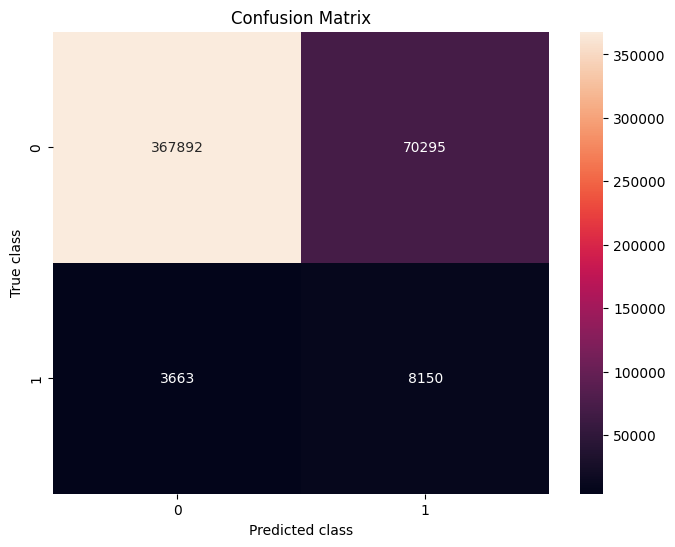

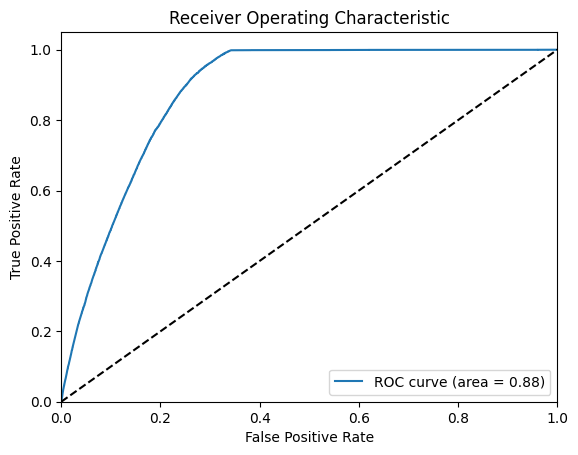


Classification Report:


,precision,recall,f1-score,support
0,0.990141,0.839578,0.908665,438187.000000
1,0.103894,0.689918,0.180593,11813.000000
accuracy,0.835649,0.835649,0.835649,0.835649
macro avg,0.547018,0.764748,0.544629,450000.000000
weighted avg,0.966876,0.835649,0.889552,450000.000000



Results for CatBoostClassifier:

ROC AUC Score:
0.5182208906501711


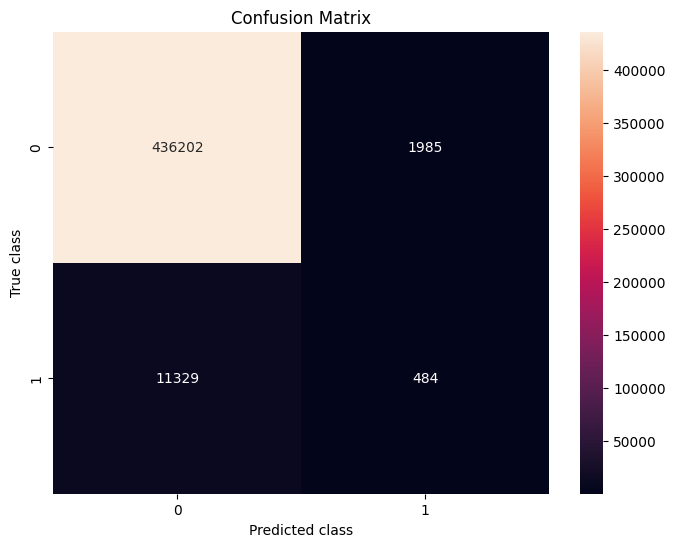

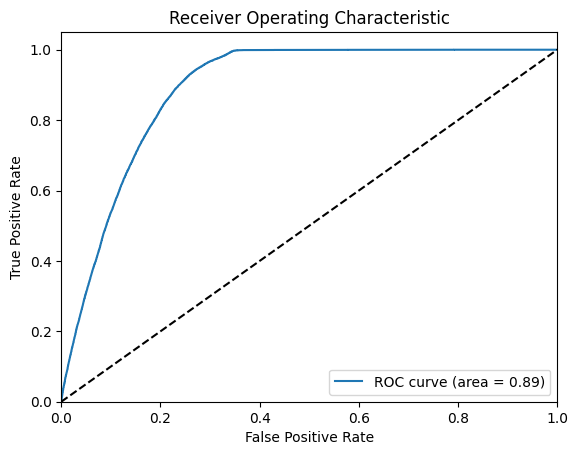


Classification Report:


,precision,recall,f1-score,support
0,0.974686,0.995470,0.984968,438187.000000
1,0.196031,0.040972,0.067778,11813.000000
accuracy,0.970413,0.970413,0.970413,0.970413
macro avg,0.585358,0.518221,0.526373,450000.000000
weighted avg,0.954245,0.970413,0.960891,450000.000000



Results for LGBMClassifier:

ROC AUC Score:
0.5557243150705332


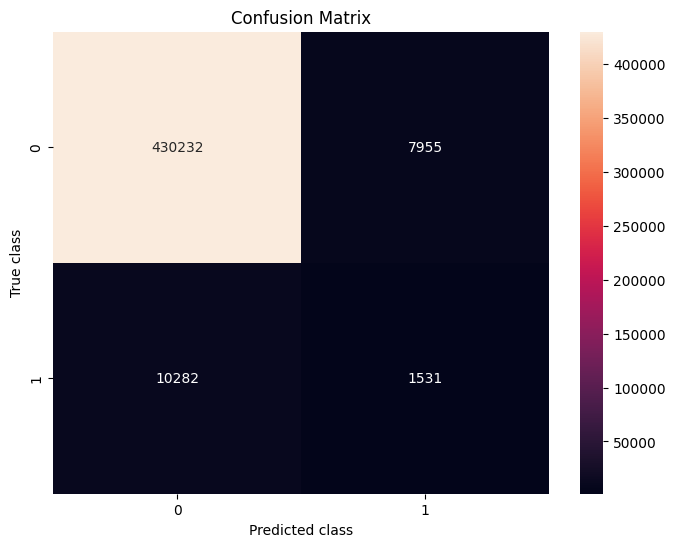

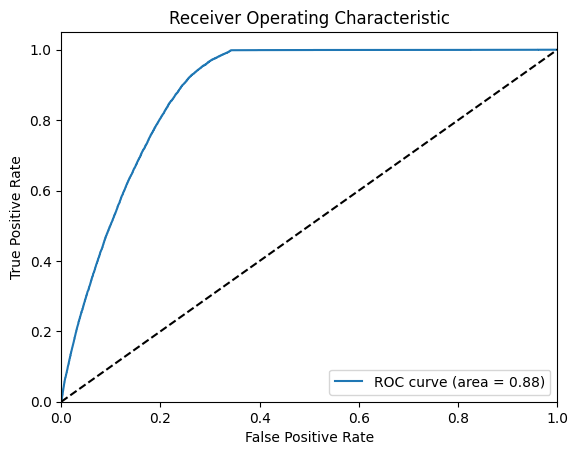


Classification Report:


,precision,recall,f1-score,support
0,0.976659,0.981846,0.979245,438187.000000
1,0.161396,0.129603,0.143763,11813.000000
accuracy,0.959473,0.959473,0.959473,0.959473
macro avg,0.569027,0.555724,0.561504,450000.000000
weighted avg,0.955258,0.959473,0.957313,450000.000000


In [ ]:
for model_name, model in trained_models.items():
    print(f"Results for {model_name}:")
    plot_model(X_test_transformed, y_test, model=model, visualize=True)

Данные были анализированы с использованием четырех различных моделей классификации: CatBoostClassifier, GradientBoostingClassifier, LGBMClassifier и LogisticRegression. Чтобы определить, какая из этих моделей лучше всего предсказывает класс 1, мы оцениваем их по следующим ключевым метрикам: точность (precision), полнота (recall) и F1-мера.

- **Точность (Precision)**: Это метрика, которая говорит нам, какой процент прогнозов модели для класса 1 действительно является точным. Высокая точность означает, что большинство прогнозов модели для класса 1 корректны.

- **Полнота (Recall)**: Эта метрика показывает нам, какой процент реальных примеров класса 1 модель смогла правильно идентифицировать. Высокая полнота означает, что модель хорошо справляется с обнаружением класса 1.

- **F1-мера**: Это средневзвешенное значение точности и полноты. Эта метрика учитывает обе предыдущие метрики и дает нам общую оценку эффективности модели в предсказании класса 1.

Из данных следует, что CatBoostClassifier имеет наибольшую полноту, но самую низкую точность среди всех моделей. Это означает, что она успешно обнаруживает большинство примеров класса 1, но в то же время делает много ошибок, относя некоторые примеры к классу 1, когда они туда не относятся.

С другой стороны, GradientBoostingClassifier и LGBMClassifier показывают немного более низкую полноту, но их точность значительно выше по сравнению с CatBoostClassifier. Это говорит о том, что они более аккуратно относят примеры к классу 1, делая меньше ошибок.

LogisticRegression имеет самую низкую полноту, что означает, что эта модель пропускает более высокий процент примеров класса 1 по сравнению с другими моделями.

В зависимости от того, что важнее для  задачи - обнаружить как можно больше примеров класса 1 (даже за счет увеличения ошибок) или сделать как можно меньше ошибок при прогнозировании класса 1, можем выбрать соответствующую модель. Если важнее обнаружение, выберим CatBoostClassifier. Если важнее точность прогнозов, рассмотрим GradientBoostingClassifier или LGBMClassifier.